# Word vectors
Optimize the word verctors for the 20 newsgroups

## Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import nltk
from nltk import word_tokenize
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.stem import WordNetLemmatizer

In [3]:
from sklearn.datasets import fetch_20newsgroups

In [4]:
import gensim
import re

## Helper functions

In [5]:
class LemmaTokenizer(object):
    def __init__(self):
         self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [6]:
def build_model(sentences, size):
    corpus_words = []
    for session in sentences:
        words = word_tokenize(session)
        session_words = []
        for word in words:
            regex_match = re.match(r"\b[a-zA-Z]+\b", word)
            if (regex_match is not None) & (len(word) > 1) & (word not in stopwords):
                session_words.append(wnl.lemmatize(word.lower()))
        corpus_words.append(session_words)
    model = gensim.models.Word2Vec(corpus_words, size=size, window=5, seed=42,
                                   min_count=2, workers=4)
    return model, corpus_words

In [7]:
def average_vectors(word_list, word2vec_dict, vec_length=5):
    avg_vector = np.zeros(vec_length)
    if len(word_list) == 0:
        return avg_vector
    for word in word_list:
        if word in word2vec_dict.keys():
            avg_vector = np.add(word2vec_dict[word], avg_vector)
    return np.divide(avg_vector, len(word_list))

## Build the dataset

In [8]:
categories = ['rec.motorcycles', 'rec.autos']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                      categories=categories)

## Rreduce data to just the content of the message

In [9]:
newsgroups_train = fetch_20newsgroups(subset='train',
                                      categories=categories,
                                      remove=('headers', 'footers', 'quotes'))
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                      categories=categories)

Aggregate each email into an average of the 100 word embeddings

In [10]:
from nltk.corpus import stopwords
stopwords = set(stopwords.words('english'))
wnl = WordNetLemmatizer()

In [11]:
model_100, corpus_words = build_model(newsgroups_train.data, 100)

In [12]:
corpus_words

[['stuff', 'deleted'],
 ['this',
  'morning',
  'truck',
  'within',
  'sight',
  'within',
  'mile',
  'suddenly',
  'forgot',
  'existed',
  'pulled',
  'right',
  'front',
  'wheel',
  'even',
  'back',
  'edge',
  'front',
  'passenger',
  'door',
  'accelerating',
  'past',
  'it',
  'trivial',
  'enough',
  'tap',
  'brake',
  'slide',
  'behind',
  'slewed',
  'signal',
  'course',
  'top',
  'little',
  'horn',
  'blaring',
  'damn',
  'need',
  'fiamms',
  'satisfaction',
  'aware',
  'surroundings',
  'thus',
  'surviving',
  'enough',
  'especially',
  'later',
  'pulled',
  'alongside',
  'bastard',
  'made',
  'apologetic',
  'wave',
  'anything',
  'is',
  'way',
  'memorize',
  'license',
  'plate',
  'offending',
  'vehicle',
  'get',
  'name',
  'address',
  'owner',
  'going',
  'firebomb',
  'house',
  'anything',
  'like',
  'write',
  'consciousness-raising',
  'letter',
  'two',
  'think',
  'would',
  'good',
  'bdi',
  'cager',
  'know',
  'we',
  'know',
  'whe

In [13]:
len(model_100.wv.vocab)

5546

In [14]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

'wave'

In [15]:
w2v = dict(zip(model_100.wv.index2word, model_100.wv.vectors))

## Vectorize the contents of the email

In [16]:
vectors = []
for email in corpus_words:
    email_vector = average_vectors(email, w2v, vec_length=100)
    vectors.append(email_vector)

In [17]:
matrix = np.array(vectors)
matrix.shape

(1192, 100)

In [18]:
from sklearn.decomposition import PCA
sns.set()

In [19]:
pca = PCA(n_components=2)

In [20]:
twod = pca.fit_transform(matrix)

In [21]:
newsgroups_train.target

array([0, 1, 1, ..., 0, 1, 0])

In [22]:
matrix.shape

(1192, 100)

In [23]:
car_emails = twod[np.where(newsgroups_train.target == 0), :][0, :, :]
moto_emails = twod[np.where(newsgroups_train.target == 1), :][0, :, :]

In [24]:
car_emails.shape

(594, 2)

Plot the vectorization of car and moto emails

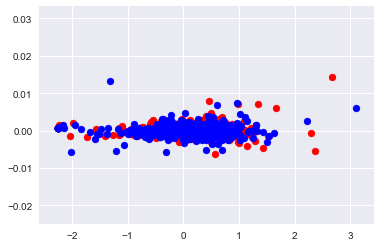

In [25]:
plt.scatter(x = car_emails[:, 0], y=car_emails[:, 1], c='r')
plt.scatter(x = moto_emails[:, 0], y=moto_emails[:, 1], c='b')

Not very sperable, see if TSNE can work as inspirded by https://blog.insightdatascience.com/automating-customer-support-when-you-lack-data-e9975fd8a053 

In [26]:
from sklearn.manifold import TSNE

In [27]:
tsne = TSNE(n_components=2, perplexity=50, early_exaggeration=12,
            learning_rate=100, n_iter=1000, n_iter_without_progress=300,
            verbose=1, method='barnes_hut')

In [28]:
tsne_twod = tsne.fit_transform(matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1192 samples in 0.004s...
[t-SNE] Computed neighbors for 1192 samples in 0.093s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1192
[t-SNE] Computed conditional probabilities for sample 1192 / 1192
[t-SNE] Mean sigma: 0.024359
[t-SNE] KL divergence after 250 iterations with early exaggeration: 45.082848
[t-SNE] Error after 1000 iterations: 0.159500


In [29]:
car_emails = tsne_twod[np.where(newsgroups_train.target == 0), :][0, :, :]
moto_emails = tsne_twod[np.where(newsgroups_train.target == 1), :][0, :, :]

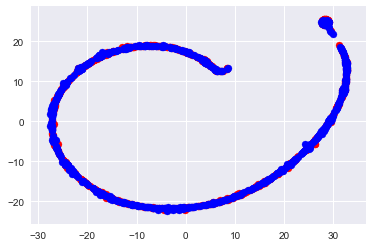

In [30]:
plt.scatter(x = car_emails[:, 0], y=car_emails[:, 1], c='r')
plt.scatter(x = moto_emails[:, 0], y=moto_emails[:, 1], c='b')

## Plot the word embeddings
Get the top 20 nouns and plot them

In [31]:
from collections import Counter

In [32]:
word_count = Counter()
for doc in newsgroups_train.data:
    word_list = [wnl.lemmatize(x.lower()) for x in doc.split() if x not in stopwords]
    word_count = word_count + Counter(word_list)

In [33]:
word_count.most_common(n=5)

[('i', 2589), ('the', 628), ('car', 524), ('would', 400), (':', 398)]

Not super helpful, hardcode the most important words

### 2D word vectorization whent training

In [34]:
model_2, corpus_words = build_model(newsgroups_train.data, 2)

In [35]:
model_2.wv['motor']

array([ 1.0760659, -2.0202281], dtype=float32)

In [59]:
labels = model_2.wv.vocab.keys()

In [60]:
car_words = ['motor', 'engine', 'wheel', 'tire', 'windshield', 'glass',
             'gasoline', 'fuel', 'speed', 'accelerate', 'throttle',
             'pad', 'wave']

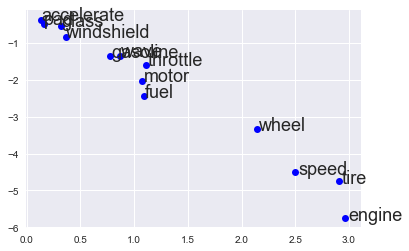

In [61]:
for word in car_words:
    x = model_2.wv[word][0]
    y = model_2.wv[word][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1+0.01), y*(1+0.01), word, fontsize=18)
plt.show()    

That doesn't make that much sense

In [62]:
model_100.wv.doesnt_match(['wheel', 'car', 'wave'])

'wave'

In [63]:
model_2.wv.doesnt_match(['wheel', 'car', 'wave'])

'car'

Reducing the 100 element word embedding to 2

In [64]:
twod = pca.fit_transform(model_100.wv.vectors)

In [65]:
twod = pd.DataFrame(data=twod, index=model_100.wv.vocab)

In [66]:
twod.shape

(5546, 2)

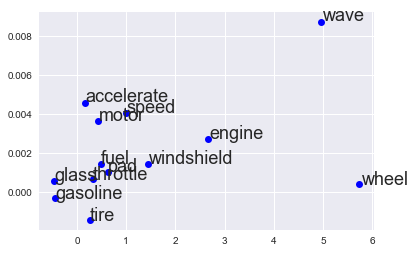

In [69]:
for word in car_words:
    x = twod.loc[word][0]
    y = twod.loc[word][1]
    plt.plot(x, y, 'bo')
    plt.text(x * (1+0.01), y*(1+0.01), word, fontsize=18)
plt.savefig('../docs/2d_custom_word_embeddings.png')
plt.show()   

In [68]:
model_100.wv.doesnt_match(['windshield', 'wiper', 'engine'])

'wiper'